## Description

---

Defects in 3D printing refer to irregularities in the printing process that affect the structure or quality of printed objects.

The main goal is to train a deep learning model to classify ongoing 3d prints into two classes: defective or no defective. The model task aims to early detect defective prints.

For the model development, I’ll start fine-tuning ResNet-15. Initially only fine-tuning the classifier layer and freezeing all the remaining layers.

**HOW TO RUN:** If you want to run the model, the only consideration is to generate Kaggle API Key, and place the kaggle.json file in the notebook folder. Alternatively, you could manually set the environment variables in the code.

On the first time run you'll need to uncomment the download code.

In [13]:
#%pip install efficientnet-pytorch

In [14]:
# Environment Variables
import os
import json
with open('kaggle.json', 'r') as f:
  data = json.load(f)
  os.environ['KAGGLE_USERNAME'] = data.get('username', None)
  os.environ['KAGGLE_KEY'] = data.get('key', None)

# Imports
import torch
import kaggle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from enum import Enum
from PIL import Image
from tqdm import tqdm
from datetime import datetime
from IPython.display import clear_output
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, recall_score, f1_score

class Backbone(Enum):
    EfficientNetb0 = 1
    ResNet18 = 2

# Constants and variables
RUN_ID = int(datetime.now().timestamp())
print(f'run_id: {RUN_ID}')

device = 'cuda'
DOWNLOAD_DATASET = False
BATCH_SIZE = 64
EPOCHS = 5
TRAINING_SPLIT = 0.7
VALIDATION_SPLIT = 0.15
DATA_PATH = 'data/Printing_Errors/images/all_images256/'
LOGS_PATH = f'logs/{RUN_ID}/'
WEIGHT_PATH = f'weights/{RUN_ID}/'
ANNOTATION_FILE = 'data/Printing_Errors/general_data/black_bed_all.csv'
FREEZE_LAYERS = True
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0
THRESHOLD = 0.55
BACKBONE = Backbone.EfficientNetb0

# Grid search params
DEFAULT_TRAIN_PARAMS = (0, EPOCHS, LEARNING_RATE, WEIGHT_DECAY, FREEZE_LAYERS, BACKBONE)
GRID_SEARCH_PARAMS = [
  DEFAULT_TRAIN_PARAMS,                                                           # Default
  (1, EPOCHS, LEARNING_RATE, WEIGHT_DECAY, FREEZE_LAYERS, Backbone.ResNet18),     # Default - Using ResNet18
  (2, EPOCHS, LEARNING_RATE, 0.001, False, BACKBONE),                             # With WEIGHT_DECAY, Unfreezed hidden layers
  (3, 10, LEARNING_RATE, WEIGHT_DECAY, FREEZE_LAYERS, BACKBONE),                  # 10 EPOCHS - Freezed layers
  (4, 10, LEARNING_RATE, 0.001, False, BACKBONE),                                 # 10 EPOCHS - With WEIGHT_DECAY, Unfreezed hidden layers
  (5, 20, LEARNING_RATE, WEIGHT_DECAY, FREEZE_LAYERS, BACKBONE),                  # 20 EPOCHS - Freezed layers
  (6, 20, LEARNING_RATE, 0.001, False, BACKBONE),                                 # 20 EPOCHS - With WEIGHT_DECAY, Unfreezed hidden layers
  (7, 20, LEARNING_RATE, 0.001, False, BACKBONE),                                 # 20 EPOCHS - With WEIGHT_DECAY, Unfreezed hidden layers
  (8, 50, LEARNING_RATE, 0.001, False, Backbone.ResNet18),                                 # 20 EPOCHS - With WEIGHT_DECAY, Unfreezed hidden layers
  (9, 50, LEARNING_RATE, 0.001, False, BACKBONE),                                 # 20 EPOCHS - With WEIGHT_DECAY, Unfreezed hidden layers
]

# Helper function to create directories
def create_directory(path):
  directory_path = os.path.dirname(path)
  if not os.path.exists(path):
    os.makedirs(path)

# Helper function to log
def log_file(file_id, content, log_time=True):
  time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  file_path = f'{LOGS_PATH}{file_id}.log'

  message = f'{time}: {content}{os.linesep}' if log_time else f'{content}{os.linesep}'
  print(message)

  with open(file_path, 'a') as file:
    file.write(message)


run_id: 1712196611


In [15]:
# Making sure all folders exists :3
create_directory(LOGS_PATH)
create_directory(WEIGHT_PATH)

## Dataset & Data Exploration

In [16]:
# @title Download the dataset
dataset_name = 'nimbus200/3d-printing-errors'
save_dir = 'data/'

if DOWNLOAD_DATASET:
  os.makedirs(save_dir, exist_ok=True)
  kaggle.api.authenticate()
  kaggle.api.dataset_download_files(dataset_name, path=save_dir, unzip=True, quiet=False)

In [17]:
# Read csv with file directory
df = pd.read_csv(ANNOTATION_FILE, delimiter=';')
df.head(5)

,image,class,layer,nozzle,filament,ex_mul,retraction,layer_height,filament_color,shape,recording,printbed_color,extrusion_multiplier,extrusion_std,modified_layers,brightness,mean_brightness
0,ELP_12MP_01.12.2022_166990882982.png,0,4,0.4,PLA,1.05,8.0,0.3,gray,1,Recording_01122022_15_27_47,black,NaN,NaN,NaN,164,145
1,ELP_12MP_01.12.2022_166990882986.png,0,4,0.4,PLA,1.05,8.0,0.3,gray,1,Recording_01122022_15_27_47,black,NaN,NaN,NaN,157,145
2,ELP_12MP_01.12.2022_166990887746.png,0,5,0.4,PLA,1.05,8.0,0.3,gray,1,Recording_01122022_15_27_47,black,NaN,NaN,NaN,150,145
3,ELP_12MP_01.12.2022_166990887749.png,0,5,0.4,PLA,1.05,8.0,0.3,gray,1,Recording_01122022_15_27_47,black,NaN,NaN,NaN,161,145
4,ELP_12MP_01.12.2022_166990892905.png,0,6,0.4,PLA,1.05,8.0,0.3,gray,1,Recording_01122022_15_27_47,black,NaN,NaN,NaN,160,145


The dataset comes with the following classes:
* 0 GOOD
* 1 UNDEREXTRUSION
* 2 STRINGING
* 4 SPAGHETTI

For project task, defective classes are going to be merged, now all of them representing the class defective (1), as a result the dataset labels are:

* 0 Good
* 1 Defective

In [18]:
class_mapping = {0: 0, 1: 1, 2: 1, 4: 1}
df['class'] = df['class'].replace(class_mapping)

Classes: 0=Good 1=Defective


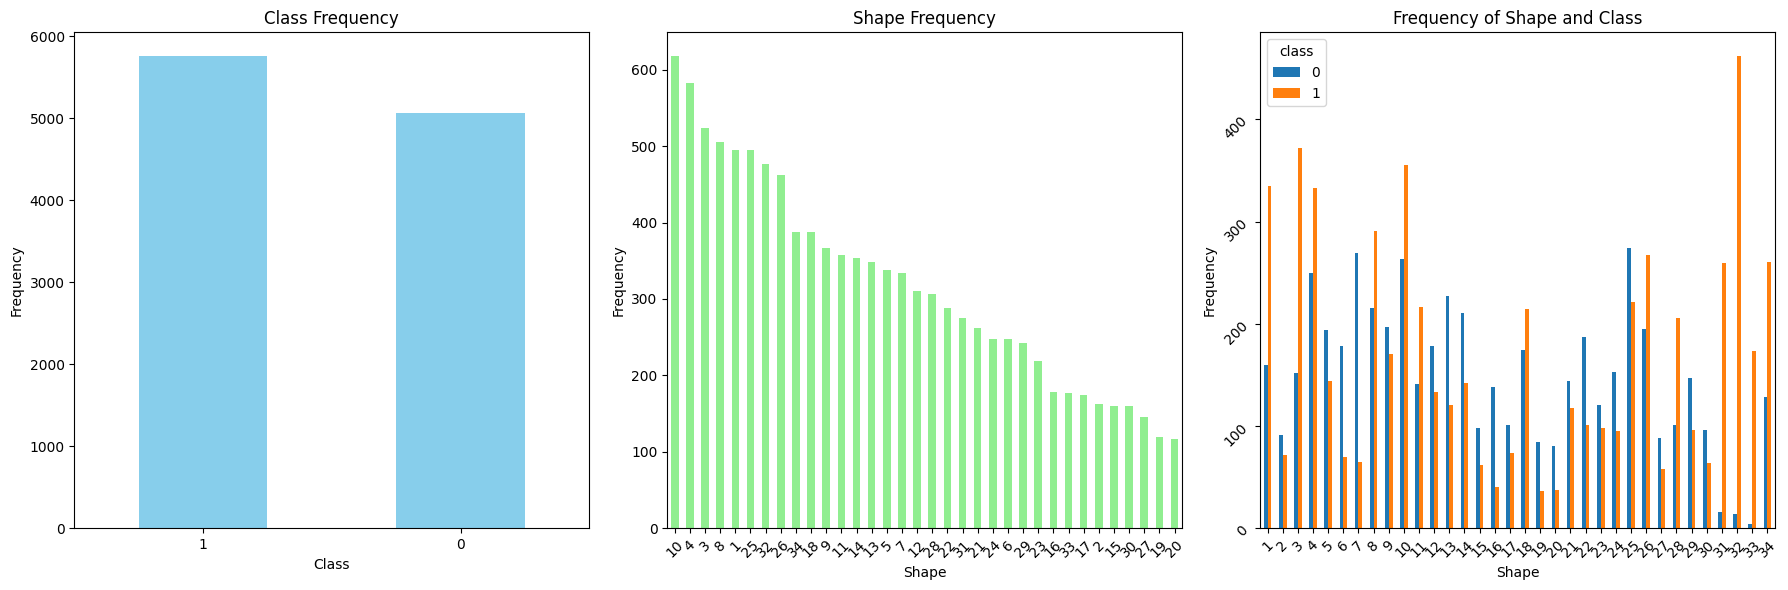

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
print('Classes: 0=Good 1=Defective')

# Class frequency
class_frequencies = df['class'].value_counts();
class_frequencies.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Class Frequency')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=0)

# Shape frequency
shape_frequencies = df['shape'].value_counts()
shape_frequencies.plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Shape Frequency')
axes[1].set_xlabel('Shape')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

# Shape/Class Frequency
grouped_data = df.groupby(['shape', 'class']).size().unstack(fill_value=0)
grouped_data.plot(kind='bar', ax=axes[2])
axes[2].set_title('Frequency of Shape and Class')
axes[2].set_xlabel('Shape')
axes[2].set_ylabel('Frequency')
axes[2].tick_params(rotation=45)
plt.tight_layout()
plt.show()

The dataset labels frequency show a slight unbalance towards the 'defective' class, which is a fair start point.

The images of the prints are from 34 different shapes, which frequencies are unbalanced. Also, shapes have different complexities, suggesting that the model may perform better on certain shapes than others, It'll ultimately depend of how good the model will generalize the shapes and errors. I expect the model to perform better on simpler shapes.

If needed, it can be balanced with data augmentation or undersampling, TBD depending the project development .

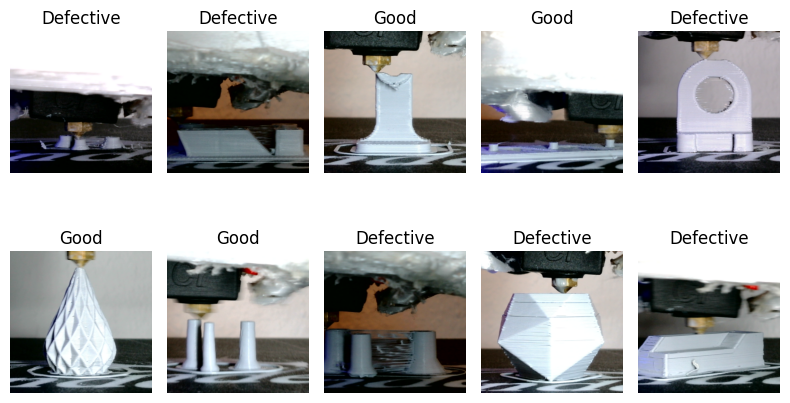

In [20]:
# @title Dataset visualization

image_df  = df[['image', 'class']].sample(10)
image_df['image'] = DATA_PATH + df['image']
images = []

# Plot images with corresponding classes
fig, axes = plt.subplots(2, 5, figsize=(8, 5))

for idx, (image_path, class_label) in enumerate(zip(image_df['image'], image_df['class'])):
    row = idx // 5
    col = idx % 5

    img = Image.open(image_path)

    axes[row, col].imshow(img)
    axes[row, col].set_title('Good' if class_label == 0 else 'Defective')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [21]:
# @title Load images and convert to torch dataset
class PrintingErrorsDataset(Dataset):
  def __init__(self, data_path, files, labels, shapes, transform=None):
    self.data_path = data_path
    self.files = files
    self.labels = labels
    self.shapes = shapes
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = Image.open(self.data_path + self.files[idx])
    label = self.labels[idx]

    if self.transform:
        img = self.transform(img)

    return img, label

### Dataset split
70% Training - 15% Validation - 15% Testing

In [22]:
files = df['image']
labels = df['class']
shapes = df['shape']

train_split = int(TRAINING_SPLIT * len(files))
val_split = int(VALIDATION_SPLIT * len(files))
test_split = len(files) - train_split - val_split

# Transformations (Since using EfficientNetb0 trained on IMAGENET1K_V1, ImageNet transforms will be applied)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset instantiation and split
dataset = PrintingErrorsDataset(DATA_PATH, files, labels, shapes, transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_split, val_split, test_split])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



## Model Definition

For the sake of trying new models I made this model able to use either `ResNet18` or `EfficientNetb0` as backbone.

If `FREEZE_LAYERS` is set to `True`, it'll freeze all layers but the classifier layer (which is overrided). Else, it won't freeze any layer and backpropagation will update all layers.

---

The main reason to try EfficientNet is to try to improve performance with a similar amount of resources, as shown in this image:
<figure>
<img src="https://i.imgur.com/ScsF2OF.png">
<figcaption>https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142</figcaption>
</figure>


In [23]:
class PrintNet(nn.Module):
  def __init__(self, freeze_layers, backbone, num_classes=1):
    super(PrintNet, self).__init__()

    # ResNet18 & EfficientNet weights pretrained with ImageNet
    if backbone == Backbone.ResNet18:
      self.backbone = models.resnet18(pretrained=True)
      num_features = self.backbone.fc.in_features
      self.backbone.fc = nn.Linear(num_features, num_classes)
    elif backbone == Backbone.EfficientNetb0:
      self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
      num_features = self.backbone._fc.in_features
      self.backbone._fc = nn.Linear(num_features, num_classes)

    if freeze_layers:
      for param in self.backbone.parameters():
        param.requires_grad = False

    # ResNet18 & EfficienNet have different names for the fc layer
    if backbone == Backbone.ResNet18:
      for param in self.backbone.fc.parameters():
        param.requires_grad = True
    elif backbone == Backbone.EfficientNetb0:
      for param in self.backbone._fc.parameters():
        param.requires_grad = True

  def forward(self, x):
    x = self.backbone(x)
    x = torch.sigmoid(x)

    return x

def instantiate_model(learning_rate, weight_decay, freeze_layers, backbone):
  model = PrintNet(freeze_layers, backbone).to(device)

  criterion = nn.BCELoss()

  if backbone == Backbone.ResNet18:
    optimizer = optim.Adam(model.backbone.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif backbone == Backbone.EfficientNetb0:
    optimizer = optim.Adam(model.backbone._fc.parameters(), lr=learning_rate, weight_decay=weight_decay)

  return model, criterion, optimizer

### Evaluation Definition

In [24]:
def evaluate(model, dataloader):
  model.eval()

  correct = 0
  total = 0
  running_loss = 0
  predictions = []
  ground_true = []
  losses = []
  prob_outputs = []

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.float().to(device)

      outputs = model(inputs).squeeze()
      loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      predicted = (outputs > THRESHOLD).int()
      predictions += predicted
      ground_true += labels

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      prob_outputs += outputs

  val_loss = running_loss / len(dataloader.dataset)
  accuracy = correct / total
  #print(f'\nEvaluation Accuracy: {accuracy:.2%}')
  model.train()
  return accuracy, val_loss, predictions, ground_true, prob_outputs

### Training Definition

In [25]:
# Model Training
def train_model(id, model, criterion, optimizer, dataloader, epochs):
  model.train()

  train_losses = []
  train_accuracy = [] #TODO
  val_losses = []
  val_accuracy = []

  for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.float().to(device)

      optimizer.zero_grad()

      outputs = model(inputs).squeeze()
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    accuracy, val_loss, _, _, _  = evaluate(model, val_loader)
    val_losses.append(val_loss)
    #val_accuracy.append(accuracy)

    # Epoch Results
    print('') # Something is messing with the tqdm end of line :( - hardcoded fix
    log_file(id, f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}')
    log_file(id, f'Validation Accuracy: {accuracy:.4f}')

  print('\nFinished Training')
  return train_losses, val_losses

### Model Training

In [ ]:
for params in GRID_SEARCH_PARAMS:
  id, epochs, learning_rate, weight_decay, freeze_layers, backbone = params
  model, criterion, optimizer = instantiate_model(learning_rate, weight_decay, freeze_layers, backbone)

  log_file(id, f'Starting training: ({epochs}) Epochs - ({learning_rate}) Learning Rate - ({weight_decay}) Weight Decay - ({freeze_layers}) Freezed Layers - {backbone.name}', False)

  train_losses, val_losses = train_model(id, model, criterion, optimizer, train_dataset, epochs)

  # Save Model training losses and val accuracies
  training_df = pd.DataFrame({'training_loss': train_losses, 'val_loss': val_losses })
  training_df.to_csv(f'{WEIGHT_PATH}{id}.csv', index=False)

  # Save model weights
  model_weight_path = f'{WEIGHT_PATH}{id}.pth'
  torch.save(model.state_dict(), model_weight_path)

  clear_output(wait=True)

In [27]:
#path = 'weights/default/'
model_count = 7
path = WEIGHT_PATH

trained_models = []

# load model weights & training tracking values
for i in range(model_count):
  id, epochs, learning_rate, weight_decay, freeze_layers, backbone = GRID_SEARCH_PARAMS[i]
  model, criterion, optimizer = instantiate_model(learning_rate, weight_decay, freeze_layers, backbone)

  training_records = pd.read_csv(f'{path}{i}.csv')

  model.load_state_dict(torch.load(f'{path}{i}.pth'))
  model.eval()

  trained_models.append((model, training_records))

Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


### Testing

In [28]:
testing_results = []
for model, training_records in trained_models:
  accuracy, loss, predictions, ground_true, prob_outputs = evaluate(model, test_loader)

  predictions = [tensor.item() for tensor in predictions]
  ground_true = [tensor.item() for tensor in ground_true]
  prob_outputs = [tensor.item() for tensor in prob_outputs]

  testing_results.append((predictions, ground_true, prob_outputs, accuracy, training_records))

Model 0: (0.9262) Accuracy - (05) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - EfficientNetb0
Model 1: (0.8905) Accuracy - (05) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - ResNet18
Model 2: (0.9298) Accuracy - (05) Epochs - (0.001) Weight Decay	 - (False) Freezed Layers	 - EfficientNetb0
Model 3: (0.9502) Accuracy - (10) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - EfficientNetb0
Model 4: (0.9532) Accuracy - (10) Epochs - (0.001) Weight Decay	 - (False) Freezed Layers	 - EfficientNetb0
Model 5: (0.9643) Accuracy - (20) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - EfficientNetb0
Model 6: (0.9649) Accuracy - (20) Epochs - (0.001) Weight Decay	 - (False) Freezed Layers	 - EfficientNetb0


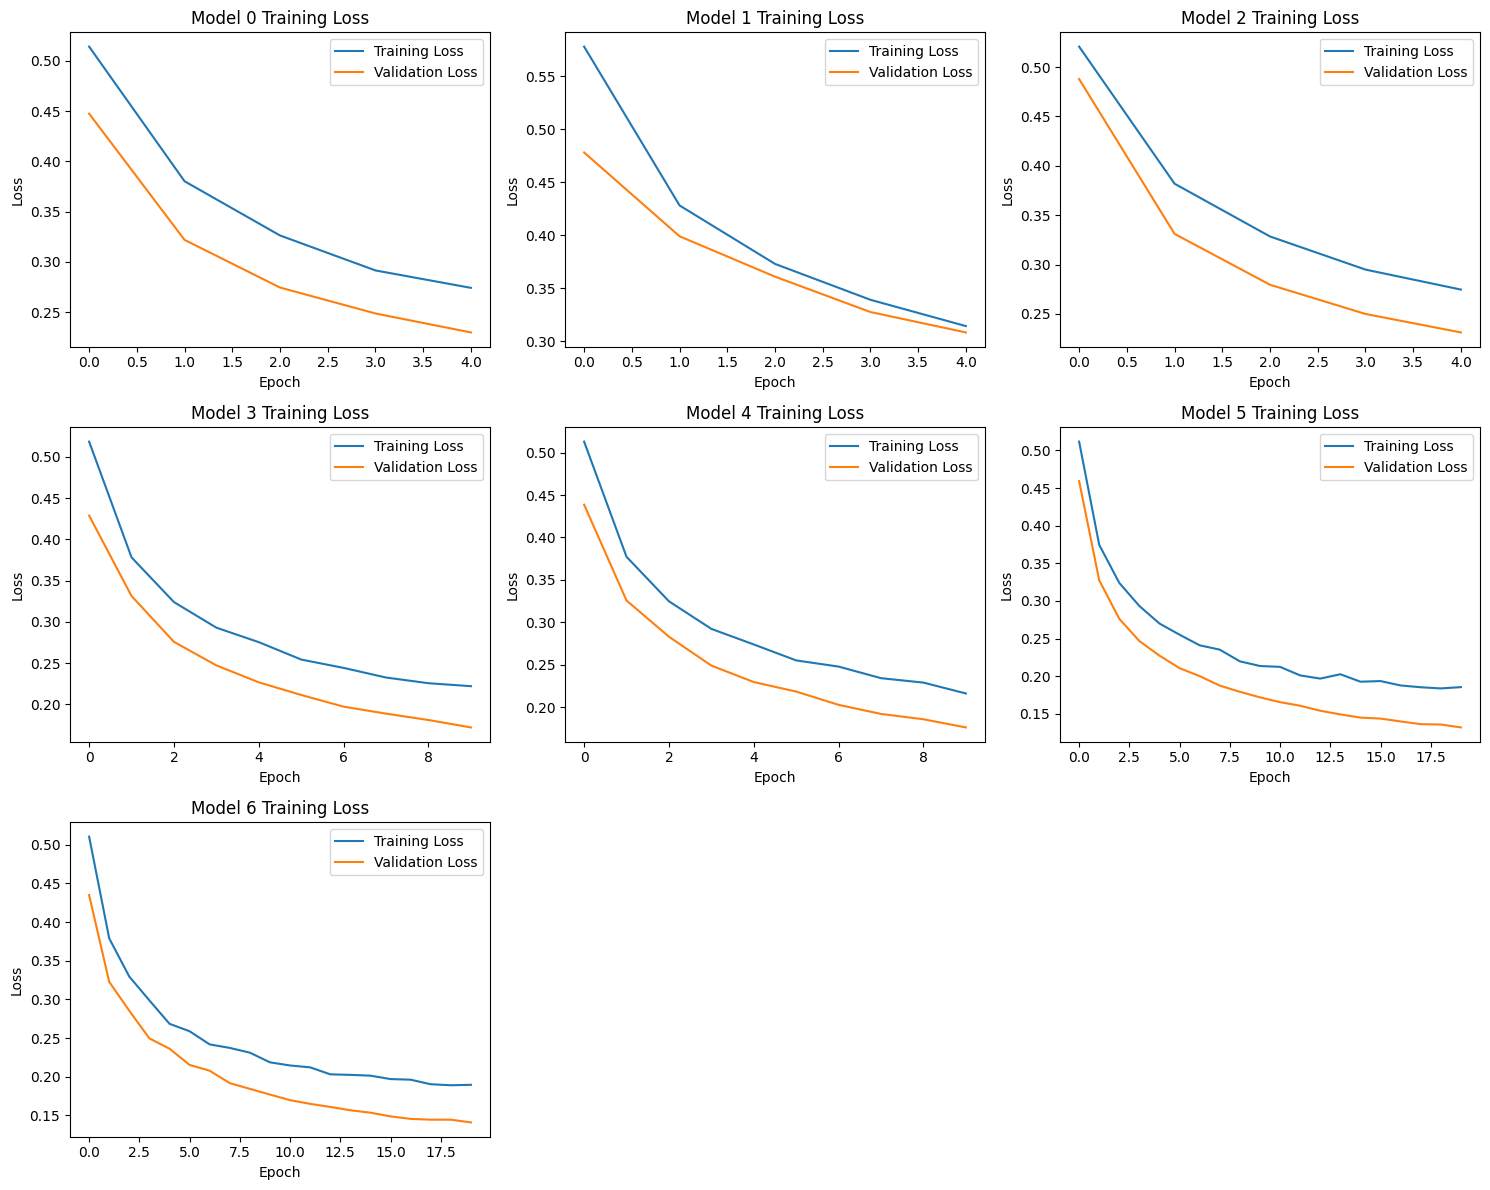

In [29]:
n_cols = 3
n_rows = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axs = axs.flatten() if len(testing_results) > 1 else [axs]

for i, results in enumerate(testing_results):
  id, epochs, learning_rate, weight_decay, freeze_layers, backbone = GRID_SEARCH_PARAMS[i]
  _, _, _, accuracy, trained_records = results
  print(f'Model {i}: ({accuracy:.4f}) Accuracy - ({epochs:02}) Epochs - ({weight_decay:.3f}) Weight Decay\t - ({freeze_layers}) Freezed Layers\t - {backbone.name}')
  axs[i].plot(trained_records['training_loss'], label='Training Loss')
  axs[i].plot(trained_records['val_loss'], label='Validation Loss')
  axs[i].set_title(f'Model {i} Training Loss')
  axs[i].set_xlabel('Epoch')
  axs[i].set_ylabel('Loss')
  axs[i].legend()

for j in range(i+1, n_cols*n_rows):
    axs[j].axis('off')

plt.tight_layout()
plt.show()




For this model 7 different configurations were run, some of the finds:
- The accuracy range is [0.8862 - 0.9575]. The models seems to perform overall very well on this task.
- Models trained with all hidden layers frozen performed better.

Model 0: (0.9262) Accuracy - (0.9288) F1 Score - (05) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - EfficientNetb0
Model 1: (0.8905) Accuracy - (0.8970) F1 Score - (05) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - ResNet18
Model 2: (0.9298) Accuracy - (0.9346) F1 Score - (05) Epochs - (0.001) Weight Decay	 - (False) Freezed Layers	 - EfficientNetb0
Model 3: (0.9502) Accuracy - (0.9530) F1 Score - (10) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - EfficientNetb0
Model 4: (0.9532) Accuracy - (0.9563) F1 Score - (10) Epochs - (0.001) Weight Decay	 - (False) Freezed Layers	 - EfficientNetb0
Model 5: (0.9643) Accuracy - (0.9667) F1 Score - (20) Epochs - (0.000) Weight Decay	 - (True) Freezed Layers	 - EfficientNetb0
Model 6: (0.9649) Accuracy - (0.9674) F1 Score - (20) Epochs - (0.001) Weight Decay	 - (False) Freezed Layers	 - EfficientNetb0


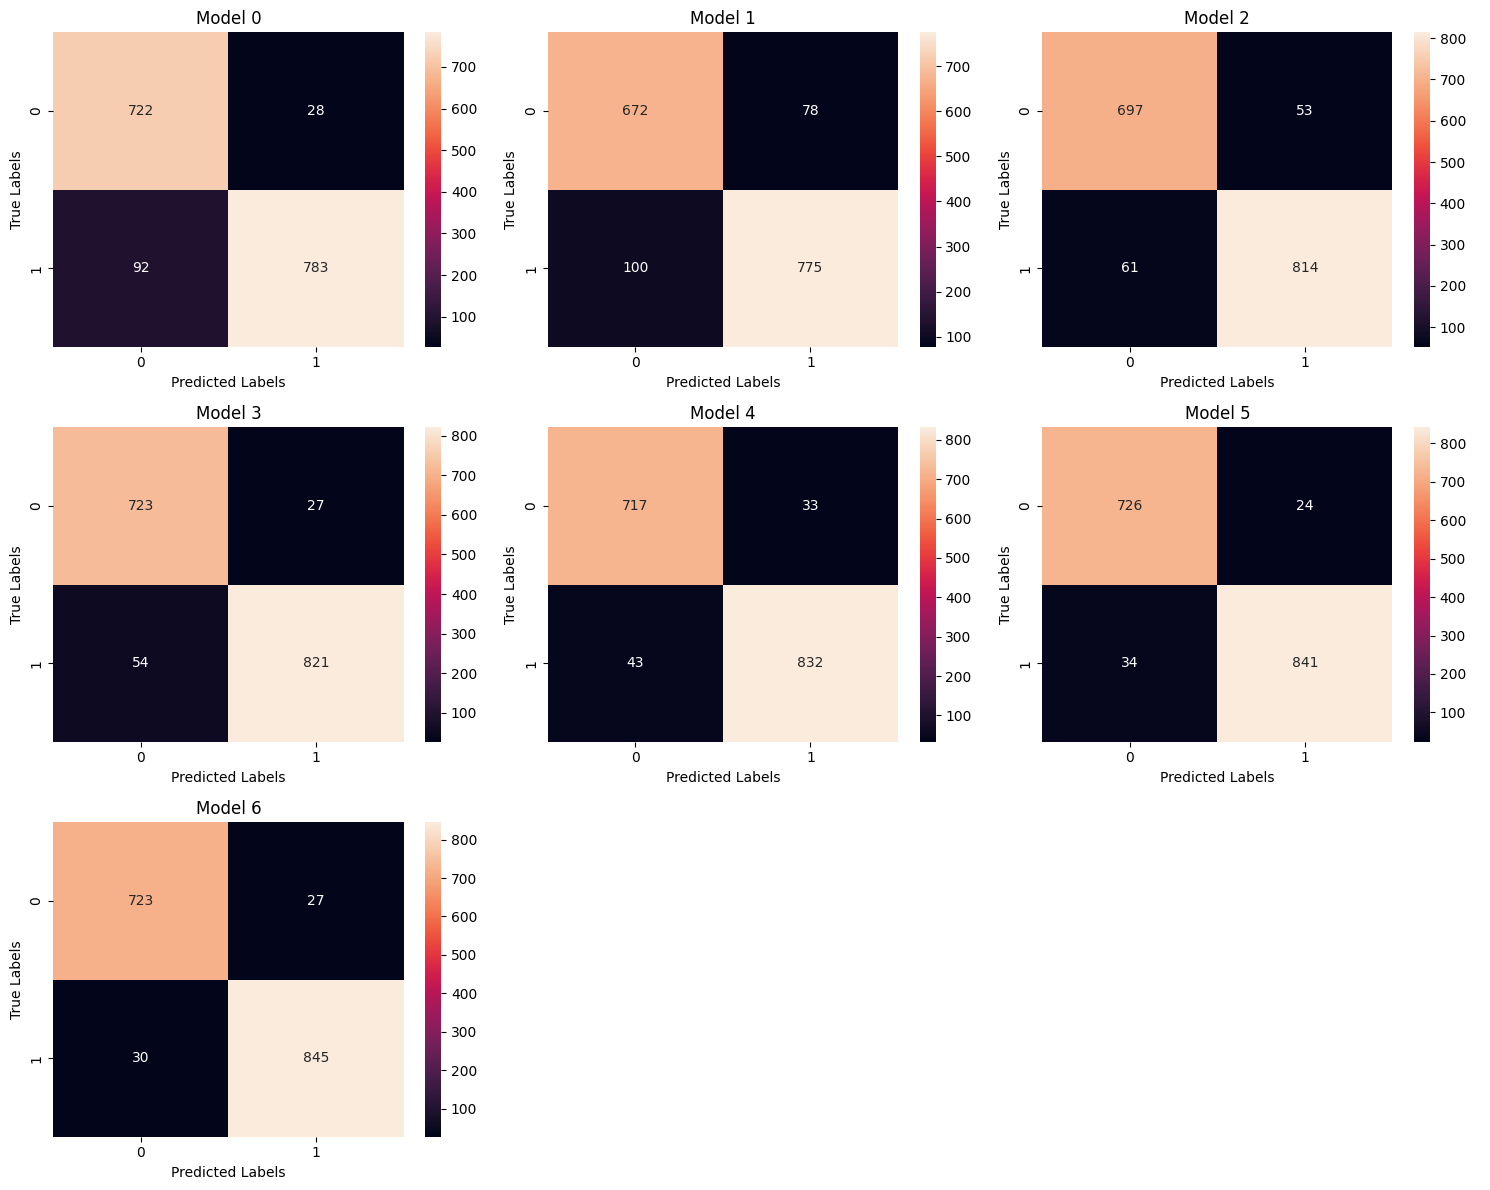

In [30]:

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axs = axs.flatten() if len(testing_results) > 1 else [axs]

for i, results in enumerate(testing_results):
  id, epochs, learning_rate, weight_decay, freeze_layers, backbone = GRID_SEARCH_PARAMS[i]
  predictions, ground_true, prob_outputs, accuracy, _ = results

  cm = confusion_matrix(ground_true, predictions)

  binary_predictions = (np.array(prob_outputs) > THRESHOLD).astype(int)
  f1 = f1_score(ground_true, binary_predictions)

  sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
  print(f'Model {i}: ({accuracy:.4f}) Accuracy - ({f1:.4f}) F1 Score - ({epochs:02}) Epochs - ({weight_decay:.3f}) Weight Decay\t - ({freeze_layers}) Freezed Layers\t - {backbone.name}')
  axs[i].set_title(f'Model {i}')
  axs[i].set_xlabel('Predicted Labels')
  axs[i].set_ylabel('True Labels')

for j in range(i+1, n_cols*n_rows):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


The models consistently tends to

---

Initially the `Threshold` was set arbitrary to 0.7, which led to an accuracy around ~0.87.

To find an optimal value for the `Threshold` I used a ROC curve to try to find a `Threshold` value that maximizes f1-score.
The plot shows that values around ~(0.50-0.58) are in the optimal range.


Optimal Threshold: 0.5454545454545455


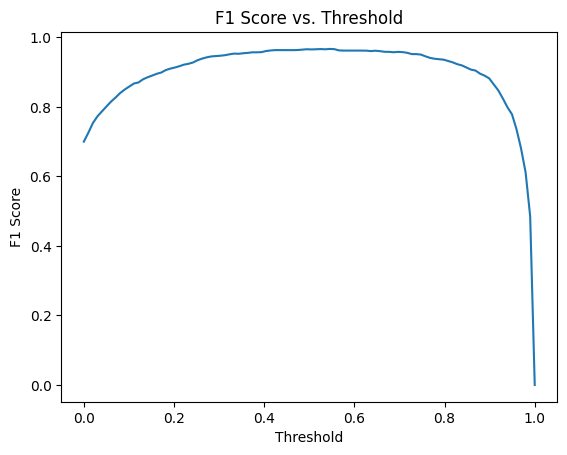

In [31]:
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds:
    binary_predictions = (prob_outputs > thresh).astype(int)
    f1 = f1_score(ground_true, binary_predictions)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()
#https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=AUC%20represents%20the%20probability%20that,has%20an%20AUC%20of%201.0.